### Toxicity classification using LSTM

Classifying comments to 3 categories: zero-tolerance, offensive, and fine using Keras

In [1]:
#importing libraries
import sys, os, re, csv, codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Loading the train dataset in colab:

In [3]:
from google.colab import files
uploaded = files.upload()

Saving all.csv to all.csv


In [4]:
import io
data = pd.read_csv(io.BytesIO(uploaded['all.csv']))

In [5]:
from google.colab import files
uploaded = files.upload()

Saving ONGO.csv to ONGO.csv


In [6]:
import io
ongo_test = pd.read_csv(io.BytesIO(uploaded['ONGO.csv']))

Looking at the sample of the dataset:

In [7]:
data[data['hate']==1].sample(5)

,text,hate,offensive,ok
74876,Halfway decent map of what? You stupid cock-su...,1,0,0
205356,don t call someone a fat ugly whore you guys h...,1,0,0
202628,suck my fuckin dick,1,0,0
77150,"FUCK YOU THUE \n\nYOU BRAIN DEAD FUCK, YOU CAN...",1,0,0
206445,r politics will come to your house and murder ...,1,0,0


In [8]:
ongo_test.sample(5)

,text
6788,"Well done Jon - as Nate says, building a solid..."
9824,I am sooo sorry your IT band is screaming. You...
2742,Way to go Joe !! Love the video.\n
758,"Yep same here. Sore in same areas, I’ve notic..."
4096,question? How do you ensure that you don’t get...


Is there any null values in the datasets:

In [9]:
data.dtypes

text         object
hate          int64
offensive     int64
ok            int64
dtype: object

In [10]:
data.isnull().any()

text         False
hate         False
offensive    False
ok           False
dtype: bool

In [11]:
ongo_test.isnull().any()

text    False
dtype: bool

In [12]:
data = data.sample(frac=1)

Creating test dataset from the training dataset:

In [13]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, test_size=0.1, random_state=42)

In [14]:
df_test.head(5)

,text,hate,offensive,ok
20150,RT @thecoreyholcomb: Long finger dike hoes be ...,0,1,0
89576,My edit is correct. See Talk:Madagascar: Escap...,0,0,1
123422,When the mood takes me I wank into a sock. It ...,0,1,0
62666,Unblock my talkpage now.,0,0,1
67104,Familicide==\nI just created a new page on Fam...,0,0,1


Some cleaning on the dataset:

In [15]:
def clean_text(text):
    #text = text.lower()
    text = re.sub(r"what's","what is", text)
    text = re.sub(r"rt", '',text)
    text = re.sub(r"\'ve","have", text)
    text = re.sub(r"can't","cannot",text)
    text = re.sub(r"n't", "not", text)
    text = re.sub(r"i'm","i am", text)
    text = re.sub(r"\'re'","are", text)
    text = re.sub(r"\'d'","would",text)
    text = re.sub(r"\'ll'", "will", text)
    text = re.sub(r"\'scuse'", "excuse", text)
    text = re.sub("\W",' ', text)
    text = re.sub('\s+',' ',text)
    text = text.strip(' ')
    return text
df_train['cmt'] = df_train['text'].map(lambda x: clean_text(x))
df_test['cmt'] = df_test['text'].map(lambda x: clean_text(x))
ongo_test['cmt'] = ongo_test['text'].map(lambda x: clean_text(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


There are 3 different columns on the dataset (hate, offensive, and ok). 
Here we are defining x and y:

In [16]:
list_classes = ['hate','offensive','ok']
y = df_train[list_classes]
x = df_train['cmt']

In [17]:
y_test = df_test[list_classes].values
x_test = df_test['cmt']

In [18]:
x_ongo_test = ongo_test['cmt']

Tokenization (breaking down the sentence into unique words), Indexing (indexing each word eg), and Index Representation are all done using:

In [19]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x))
list_tokenized_x = tokenizer.texts_to_sequences(x)

list_tokenized_x_test = tokenizer.texts_to_sequences(x_test)

list_tokenized_x_ongo_test = tokenizer.texts_to_sequences(x_ongo_test)

If you need to download the tokenizer you can use the comments below (currently deactive):

In [20]:

#tokenizer.word_counts
#tokenizer.word_index

In [21]:
#import pickle
#pickle.dump(tokenizer,open("TK.pkl","wb"))

In [22]:
#with open('TK.pkl','rb') as f:
#    TK = pickle.load(f)

In [23]:
#print(TK.texts_to_sequences(x_test[1]))

In [24]:
#from google.colab import files
#files.download("TK.pkl")

To just check how tokenizer works:

In [25]:
x_test[:1]
print(list_tokenized_x[:1])


[[16606, 16606, 609, 1622, 36, 7508, 33, 28, 1302, 13, 8, 180, 44, 1, 5196, 83, 4, 20, 895, 199, 32, 29, 1162, 376, 7, 21, 179, 800, 7, 533, 78, 10, 814, 2, 8740, 1, 213, 61, 4, 196, 556, 184, 6, 1, 213, 61, 4, 92, 21, 2, 1487, 91, 17, 5, 960, 381, 10, 25, 6983, 4, 85, 363, 160, 8908, 146, 13, 2615, 2, 1487, 67, 85, 928, 722, 4, 806, 160, 16, 251, 2, 17097, 1, 1394, 11, 80, 1946, 44, 104, 6, 21, 191, 1357, 350, 9, 3, 25, 1692, 2888, 16607, 17, 1, 903, 87, 691, 43, 3, 332, 92, 25, 2347, 16607, 7, 91, 5, 960, 6, 181, 2, 1, 376, 9, 2360, 10, 276, 1409, 7, 960, 3248, 3477, 73, 22, 376, 8, 1121, 1576, 26, 1965, 559, 87, 9, 10, 47, 57, 1217, 2, 16, 377, 21, 600, 9353, 7, 9, 376, 2, 287, 6, 99, 10, 150, 44, 3, 25, 5, 1576, 1483, 8, 87, 5, 349, 7, 903, 928, 13, 359, 574, 123, 4, 2236, 10, 55, 59, 94, 16607, 18, 1877, 12, 21, 2325, 2596, 163]]


Doing some EDA on the data, I decided to limit the maximum length of comments to 200 words. To keep the length of all 200 I used padding:

In [26]:
maxlen = 200

X_train = pad_sequences(list_tokenized_x, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_x_test, maxlen=maxlen)
X_test_ongo = pad_sequences(list_tokenized_x_ongo_test)
X_train

array([[   0,    0,    0, ..., 2325, 2596,  163],
       [   0,    0,    0, ...,  252,   10,   40],
       [   0,    0,    0, ...,   85,    5,  450],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    5,  298,  233],
       [   0,    0,    0, ...,   11, 7219, 1616]], dtype=int32)

To check the distribution of number of words in a sentence:

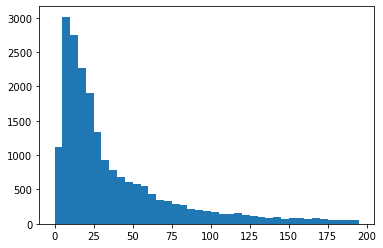

In [27]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_x_test]
plt.hist(totalNumWords, bins= np.arange(0,200,5))
plt.show()

# Start the model:

Input layer has the dimenssion of 200 (maxlen is definrd 200):

In [ ]:
inp = Input(shape=(maxlen,))#max_len=200 as defined earlier

To just make sure that everything is fine yet:

In [ ]:
data.describe()

,hate,offensive,ok
count,216315.000000,216315.000000,216315.000000
mean,0.110427,0.122627,0.782895
std,0.313422,0.328009,0.412275
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


We pass the input to the embedding layer to define vectors, then it goes to the LSTM layer, then using Globalmaxpool to reduce dimenssion, then dense layer, dropout to deactivate some cells, again dense layer and dropout and dense layer:

In [ ]:

from keras.optimizers import SGD

def get_model():
    embed_size = 128
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True, name='lstm_layer'))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x)
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='binary_crossentropy',
            optimizer = opt,
            metrics=['accuracy'])
    return model
    
model = get_model()
batch_size = 32
epochs = 10
history = model.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
4868/4868 [==============================] - 111s 23ms/step - loss: 0.2742 - accuracy: 0.8255 - val_loss: 0.1944 - val_accuracy: 0.8920
Epoch 2/10
4868/4868 [==============================] - 109s 22ms/step - loss: 0.1512 - accuracy: 0.9128 - val_loss: 0.1382 - val_accuracy: 0.9172
Epoch 3/10
4868/4868 [==============================] - 111s 23ms/step - loss: 0.1338 - accuracy: 0.9202 - val_loss: 0.1322 - val_accuracy: 0.9199
Epoch 4/10
4868/4868 [==============================] - 113s 23ms/step - loss: 0.1254 - accuracy: 0.9240 - val_loss: 0.1315 - val_accuracy: 0.9195
Epoch 5/10
4868/4868 [==============================] - 112s 23ms/step - loss: 0.1181 - accuracy: 0.9266 - val_loss: 0.1291 - val_accuracy: 0.9232
Epoch 6/10
4868/4868 [==============================] - 112s 23ms/step - loss: 0.1130 - accuracy: 0.9293 - val_loss: 0.1205 - val_accuracy: 0.9262
Epoch 7/10
4868/4868 [==============================] - 113s 23ms/step - loss: 0.1084 - accuracy: 0.9312 - val_loss: 0

In [ ]:
#save a model
model.save('model.keras')
# Load a model
#model = keras.models.load_model('model.keras')


In [ ]:
from google.colab import files
files.download('model.keras')
#from google.colab import drive
#drive.mount('/content/gdrive')

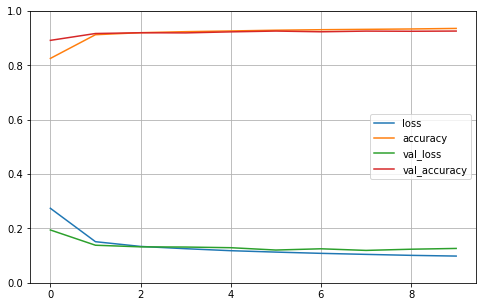

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show();

In [ ]:
model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 200, 100)          71600     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 100)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)             

In [ ]:
## Evaluating model performance and making predictions


In [ ]:
!pwd 

In [ ]:
from google.colab import files
files.download("model.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# New Section

In [ ]:
y_pred = model.predict([X_test], batch_size=1024,verbose=1)

22/22 [==============================] - 1s 32ms/step


In [ ]:
y_pred_ongo = model.predict([X_test_ongo], batch_size=1024,verbose=1)

11/11 [==============================] - 0s 43ms/step


In [ ]:
for i in range(len(y_pred_ongo)):
  if y_pred_ongo[i][0]>0.98:
    print(x_ongo_test[i])

In [ ]:
x_ongo_test[10499]

'it is an ass kicker indeed'

In [ ]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

array([[ 1714,   201,   463],
       [  209,  1993,   436],
       [   65,   137, 16414]])

In [ ]:
y_pred =reconstructed_model .predict([X_test[10:11]], batch_size=1024,verbose=1)
y_pred

NameError: ignored

In [ ]:
df_test['tweet'][10:11]

2541    ballbagsteve hoe b4 bros smh
Name: tweet, dtype: object

In [ ]:

severe_toxic = pd.DataFrame({'y_pred':y_pred[:,0],'y_test':y_test[:,0]})
severe_toxic

,y_pred,y_test
0,0.991507,1
1,0.003395,0
2,0.000046,0
3,0.000189,0
4,0.000073,0
...,...,...
21627,0.000012,0
21628,0.000013,0
21629,0.010081,0
21630,0.000015,0


In [ ]:
severe_toxic.y_pred = (severe_toxic.y_pred  > 0.9) 

In [ ]:
severe_toxic

,y_pred,y_test
0,True,1
1,False,0
2,False,0
3,False,0
4,False,0
...,...,...
21627,False,0
21628,False,0
21629,False,0
21630,False,0


In [ ]:
pd.crosstab(severe_toxic.y_pred,severe_toxic.y_test)

y_test,0,1
y_pred,,
False,19014,694
True,240,1684


In [ ]:
toxic = pd.DataFrame({'y_pred':y_pred[:,1],'y_test':y_test[:,1]})#,'Y_test':y_test})
toxic.y_pred = (toxic.y_pred > 0.9) 

In [ ]:
pd.crosstab(toxic.y_pred,toxic.y_test)

y_test,0,1
y_pred,,
False,18656,645
True,338,1993


In [ ]:
severe_toxic.y_pred.unique()

array([ True, False])

In [ ]:
pred_results =pd.DataFrame({'y_test':y_test[:,0]})#,'Y_test':y_test})

In [ ]:
from sklearn import metrics

#print(metrics.confusion_matrix(y_test,np.argmax(y_pred, axis=1)))

In [ ]:
metrics.accuracy_score(y_test, y_pred.round(), normalize=True)

0.9296875

In [ ]:
  for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.8622    0.7208    0.7852      2378
           1     0.8550    0.7555    0.8022      2638
           2     0.9673    0.9872    0.9771     16963

   micro avg     0.9455    0.9306    0.9380     21979
   macro avg     0.8948    0.8212    0.8548     21979
weighted avg     0.9424    0.9306    0.9354     21979
 samples avg     0.9455    0.9376    0.9402     21979



In [ ]:
import json
model_json = model.to_json()
with open('model.json','w')as json_file:
  json_file.write(model_json)
  print('a')
model.save_weights('model.h5')


a
